In [1]:
# Imports
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

<h2>PIPELINE:</h2>
<ol>
    <li>Load and prepare data<br></li>
    <br>
    <li>Design model<br></li>
    <br>
    <li>Define loss and optimizer<br></li>
    <br>
    <li>Training loop:<br>
        1. forward pass: compute prediction<br>
        2. backward pass: gradients<br>
        3. update weights<br>
    </li>
    <br>
    <li>Evaluate the model on validation set<br></li>
    <br>
    <li>Try to classify something<br></li>
    <br>
</ol>

-------------------------------------------------------------------------

<h1>1. Load and prepare data</h1>

In [3]:
# Load features and targetes

# Features
root_directory = './small_train_images'
study_id_list = os.listdir(root_directory)

# Targets
dirty_targets_df = pd.read_csv('./data_csv/train.csv')
rows_with_null = dirty_targets_df[dirty_targets_df.isnull().any(axis=1)]
targets_df = dirty_targets_df.dropna()

In [4]:
# Drop exceptions
exclude_1 = np.array(['100206310', '1009445512', '1018005303', '1028909382', '10728036', '1075351916', '1075863395', '108348787', '1093392148', '109454808', '1096630192', '109677683', '1104422628', '1106510276', '1117492266', '113121178', '114899184', '1166421944', '1176954132', '1178209527', '1199116491', '1228406967', '1245057921', '1246624345', '1254175796', '1258848546', '1271033295', '1288134514', '1289563234', '1332176994', '1353517692', '1354411109', '1373010257', '1378385941', '1387631768', '1417061937', '1435972903', '1452809491', '1459964234', '1465060325', '1474322336', '1476653507', '1479862846', '1504031267', '1525013622', '1531171418', '1537608176', '1544019340', '1545079332', '155064828', '1573051559', '1576224571', '1588228644', '1589542662', '1603568458', '1661682358', '1664215995', '1666392091', '1666601651', '1670838975', '1676303374', '1677607138', '169651375', '1703116521', '1722993663', '1723430291', '1737682527', '1756304277', '1777680877', '178041181', '1782095928', '1785782006', '1796029449', '1805675557', '1805845915', '1827626416', '1829899535', '1835489622', '1839242409', '1847995287', '1868615696', '1879308612', '1901348744', '1904225580', '1906657742', '1918947564', '1935490243', '1935865758', '1953361780', '1972541574', '1973833645', '1979480595', '1985516615', '200354973', '2004207983', '2009902717', '2015704745', '2026891078', '2028028580', '2072240933', '2091088734', '209512460', '2109299850', '211314658', '2139287338', '215111925', '215149692', '2162304486', '2163780658', '2178420447', '2184738913', '2196440863', '22191399', '2229950158', '2232112217', '2247118504', '2258837013', '2299500502', '2316015842', '2326232647', '2334206006', '2357870240', '2361362757', '2361533111', '2363875605', '2383459912', '2387323642', '2403128572', '2410407945', '2411161648', '2428792562', '2440904686', '2444340715', '2447825792', '245660566', '2466046363', '2470505035', '2479953750', '2490850085', '2530932856', '2568819355', '2570933394', '258027917', '259346069', '2597785056', '2608235425', '2622319181', '26342422', '2649306672', '2657109031', '2661178959', '267842058', '2691903631', '2693314432', '2701226232', '2719549572', '2754246172', '2755347468', '2758494648', '2763838004', '2797118205', '2799878304', '2802584821', '2811192798', '2814554321', '2815518245', '2826913245', '2839406005', '2851578449', '2865067754', '286903519', '2871746964', '2881985242', '2885881158', '2888359875', '289846404', '2918963439', '2925530521', '2937953357', '2953643785', '2959123241', '29931867', '3029953735', '3032490582', '3043181990', '3053259969', '305402206', '3057988981', '3068678959', '3068697362', '3109648055', '3128832901', '3138242355', '3153975178', '3156579406', '3158185203', '3160528641', '3172703788', '3185333113', '3187325767', '3192842688', '3199667842', '3234424112', '3240785276', '3270195628', '3293419987', '329807127', '3308442440', '3318343342', '3319644132', '332284668', '3329250043', '3336194522', '3337564969', '3339741647', '335455502', '3362072295', '3362964060', '3396002092', '3421594215', '3424322302', '3424519397', '3429409220', '3429410502', '3462160059', '3463837032', '347228139', '3477618714', '3478119785', '3480260143', '3486932462', '3487958667', '3489581041', '349723373', '3501721118', '3522926594', '3542358517', '3559395900', '3576859689', '3587452388', '3617361428', '3640325492', '3664042467', '3693117342', '3701224868', '3703663905', '3707028884', '3713534743', '3718047621', '3726613976', '3731783147', '3736664503', '3742728457', '3748910433', '3753583176', '375877945', '3764335465', '3768387090', '3777149998', '3808402167', '3817394595', '3819294762', '3824003946', '3836986623', '3837345060', '3853089836', '3857195576', '3859825215', '3881903999', '3882759508', '3884015124', '3887124538', '391103067', '3912497560', '3930841971', '3945605592', '3956571539', '396152094', '3996069892', '4000809387', '4017932238', '4018516468', '4020499186', '4030506789', '4035562923', '4060447686', '4072191052', '40745534', '4096820034', '4101309917', '4105233324', '4122788296', '4126793119', '4145670277', '416503281', '4165566893', '4167935162', '4171095315', '4201106871', '4205258367', '4231198665', '4259049254', '4271960965', '4279881930', '4279958262', '435244060', '435973854', '450154999', '458625588', '478913051', '481259017', '489097547', '498998339', '52695609', '560780529', '568440982', '582364168', '607371793', '619178879', '624497208', '63725508', '641070736', '652905669', '663849037', '679759364', '683183578', '684747623', '691886557', '696494906', '704573554', '766494595', '777619397', '783154228', '809072026', '838134337', '85480902', '859570985', '86250890', '870897543', '885579922', '893004686', '896290384', '89637298', '899435449', '904367529', '916362094', '924259603', '938755807', '961169106', '968668661', '3303545110', '2794192602', '3369277408', '765688458', '2661378157', '1644528034', '3867046855', '2620453928', '3324678907', '723551942', '1880970480', '642715533', '4140564625', '208289456', '2581283971', '3154638975', '1012375618', '1040921274', '1047914296'])
exclude_2 = rows_with_null.iloc[:, 0].to_numpy()
exclude_array = np.concatenate((exclude_1, exclude_2))
len(exclude_array)

554

In [5]:
# Resize images
def resize_image(image_path):
    dicom = pydicom.dcmread(image_path)
    image_array = dicom.pixel_array
    resized_image = cv2.resize(image_array, (224, 224))
    return resized_image

In [6]:
# Preprocess features
images_dict = {}
for i, study_id in enumerate(study_id_list):
    print(i+1)
    if study_id not in exclude_array:
        series_id_list = os.listdir(f'{root_directory}/{study_id}')

        for series_id in series_id_list:
            images_list = os.listdir(f'{root_directory}/{study_id}/{series_id}')

            image_arrays = []
            for idx in range(1, len(images_list)+1):
                image_path = f'{root_directory}/{study_id}/{series_id}/{idx}.dcm'
                resized_image = resize_image(image_path)
                image_arrays.append(resized_image)

            stacked_images = np.stack(image_arrays, axis=0)

            if study_id not in images_dict:
                images_dict[study_id] = [np.stack(stacked_images, axis=0)]
            else:
                images_dict[study_id].append(np.stack(stacked_images, axis=0))

max_size = 90 # max number of images in 1 study_id = 247 (90 now)
for key, arr_list in images_dict.items():
    images_dict[key] = np.concatenate(arr_list, axis=0)
    images_dict[key] = torch.from_numpy(images_dict[key])
    images_dict[key] = F.pad(images_dict[key], (0, 0, 0, 0, 0, max_size - images_dict[key].size(0)))

1
2
3
4
5
6
7
8
9
10
11
12


In [7]:
# Check features
for key, arr in images_dict.items():
    print(key, arr.shape)

11340341 torch.Size([90, 224, 224])
11943292 torch.Size([90, 224, 224])
13317052 torch.Size([90, 224, 224])
33736057 torch.Size([90, 224, 224])
4003253 torch.Size([90, 224, 224])
4646740 torch.Size([90, 224, 224])
7143189 torch.Size([90, 224, 224])
8785691 torch.Size([90, 224, 224])


In [8]:
# Prepare targets (own implementation of one-hot encoding)
target_dict = {}
for key, _ in images_dict.items():
    target = targets_df[targets_df['study_id'] == int(key)]
    transposed_df = target.iloc[:, 1:].T
    one_hot_array = []
    for _, row in transposed_df.iterrows():
        if row.values == 'Normal/Mild':
            one_hot_array.append([1, 0, 0])
        elif row.values == 'Moderate':
            one_hot_array.append([0, 1, 0])
        elif row.values == 'Severe':
            one_hot_array.append([0, 0, 1])
    target_dict[key] = torch.tensor(one_hot_array)

In [9]:
# Check targets
for key, arr in target_dict.items():
    print(key, arr.shape)

11340341 torch.Size([25, 3])
11943292 torch.Size([25, 3])
13317052 torch.Size([25, 3])
33736057 torch.Size([25, 3])
4003253 torch.Size([25, 3])
4646740 torch.Size([25, 3])
7143189 torch.Size([25, 3])
8785691 torch.Size([25, 3])


In [10]:
# Convert all tensors to float32
feature_tensors = [tensor.float() for tensor in images_dict.values()]
target_tensors = [tensor.float() for tensor in target_dict.values()]

# Stack the tensors
X_train = torch.stack(feature_tensors)
X_train = X_train / X_train.max()
y_train = torch.stack(target_tensors)

In [11]:
# Make torch DataLoader
batch_size = 6

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Check DataLoader batches
for i, train_batch in enumerate(train_loader):
    x_train_batch, y_train_batch = train_batch
    print(f'train tensor {i+1}', '|', x_train_batch.shape, '|', y_train_batch.shape)

train tensor 1 | torch.Size([6, 90, 224, 224]) | torch.Size([6, 25, 3])
train tensor 2 | torch.Size([2, 90, 224, 224]) | torch.Size([2, 25, 3])


<h1>2. Design model (input, output size, forward pass)</h1>

In [12]:
# Define hyperparmaters
num_epochs = 100
learning_rate = 0.01
input_channels = X_train.shape[1]

In [13]:
# Define the CNN model

class CNNModel(nn.Module):
    def __init__(self, input_channels):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 53 * 53, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 25*3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.reshape(x.shape[0], 25, 3)

        return x

In [14]:
# Apply and check the model
model = CNNModel(input_channels)
model.to(device)
print(model)

CNNModel(
  (conv1): Conv2d(90, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=75, bias=True)
)


In [15]:
# Basic check
x = torch.randn(2, input_channels, 224, 224)
print(model(x).shape)

torch.Size([2, 25, 3])


<h1>3. Define loss and optimizer</h1>

In [16]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<h1>4. Training loop:</h1>

In [17]:
# Training loop
losses = []
for epoch in range(num_epochs):
    for features, targets in train_loader:

        # Move data to GPU
        features, targets = features.to(device), targets.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the current loss to the list
    losses.append(loss.item())

    # Print the loss after each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 5.7963
Epoch [2/100], Loss: 1.6358
Epoch [3/100], Loss: 0.5477
Epoch [4/100], Loss: 0.2785
Epoch [5/100], Loss: 0.4960
Epoch [6/100], Loss: 0.1987
Epoch [7/100], Loss: 0.2660
Epoch [8/100], Loss: 0.2338
Epoch [9/100], Loss: 0.1994
Epoch [10/100], Loss: 0.1843
Epoch [11/100], Loss: 0.1172
Epoch [12/100], Loss: 0.2586
Epoch [13/100], Loss: 0.2176
Epoch [14/100], Loss: 0.1813
Epoch [15/100], Loss: 0.3498
Epoch [16/100], Loss: 0.3122
Epoch [17/100], Loss: 0.1699
Epoch [18/100], Loss: 0.1481
Epoch [19/100], Loss: 0.1798
Epoch [20/100], Loss: 0.1561
Epoch [21/100], Loss: 0.1661
Epoch [22/100], Loss: 0.1621
Epoch [23/100], Loss: 0.1623
Epoch [24/100], Loss: 0.1969
Epoch [25/100], Loss: 0.1499
Epoch [26/100], Loss: 0.1274
Epoch [27/100], Loss: 0.2737
Epoch [28/100], Loss: 0.1689
Epoch [29/100], Loss: 0.2056
Epoch [30/100], Loss: 0.2933
Epoch [31/100], Loss: 0.1960
Epoch [32/100], Loss: 0.1625
Epoch [33/100], Loss: 0.1700
Epoch [34/100], Loss: 0.1966
Epoch [35/100], Loss: 0

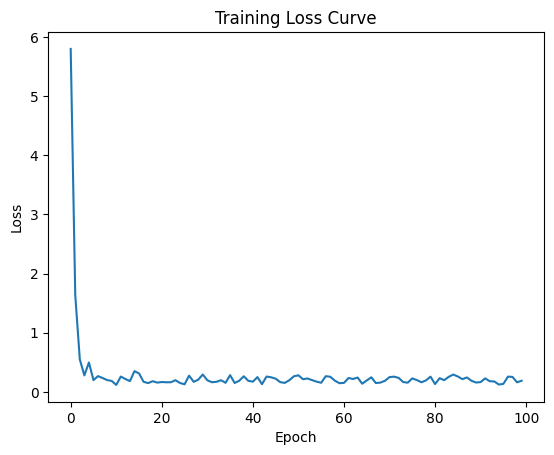

In [18]:
# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

<h1>5. Evaluate the model on dev set:</h1>

In [19]:
# Refactor the code below later!

In [20]:
# Load features and targetes

# Features
root_directory = './small_valid_images'
study_id_list = os.listdir(root_directory)

# Targets
dirty_targets_df = pd.read_csv('./data_csv/train.csv')
rows_with_null = dirty_targets_df[dirty_targets_df.isnull().any(axis=1)]
targets_df = dirty_targets_df.dropna()

# ---------------------------------------------------------------------------------

# Preprocess features
images_dict = {}
for i, study_id in enumerate(study_id_list):
    print(i+1)
    if study_id not in exclude_array:
        series_id_list = os.listdir(f'{root_directory}/{study_id}')

        for series_id in series_id_list:
            images_list = os.listdir(f'{root_directory}/{study_id}/{series_id}')

            image_arrays = []
            for idx in range(1, len(images_list)+1):
                image_path = f'{root_directory}/{study_id}/{series_id}/{idx}.dcm'
                resized_image = resize_image(image_path)
                image_arrays.append(resized_image)

            stacked_images = np.stack(image_arrays, axis=0)

            if study_id not in images_dict:
                images_dict[study_id] = [np.stack(stacked_images, axis=0)]
            else:
                images_dict[study_id].append(np.stack(stacked_images, axis=0))

max_size = 90 # max number of images in 1 study_id = 247 (90 now)
for key, arr_list in images_dict.items():
    images_dict[key] = np.concatenate(arr_list, axis=0)
    images_dict[key] = torch.from_numpy(images_dict[key])
    images_dict[key] = F.pad(images_dict[key], (0, 0, 0, 0, 0, max_size - images_dict[key].size(0)))


# ---------------------------------------------------------------------------------

# Check features
for key, arr in images_dict.items():
    print(key, arr.shape)

# ---------------------------------------------------------------------------------

# Prepare targets (own implementation of one-hot encoding)
target_dict = {}
for key, _ in images_dict.items():
    target = targets_df[targets_df['study_id'] == int(key)]
    transposed_df = target.iloc[:, 1:].T
    one_hot_array = []
    for _, row in transposed_df.iterrows():
        if row.values == 'Normal/Mild':
            one_hot_array.append([1, 0, 0])
        elif row.values == 'Moderate':
            one_hot_array.append([0, 1, 0])
        elif row.values == 'Severe':
            one_hot_array.append([0, 0, 1])
    target_dict[key] = torch.tensor(one_hot_array)

# ---------------------------------------------------------------------------------

# Check targets
for key, arr in target_dict.items():
    print(key, arr.shape)

# ---------------------------------------------------------------------------------

# Convert all tensors to float32
feature_tensors = [tensor.float() for tensor in images_dict.values()]
target_tensors = [tensor.float() for tensor in target_dict.values()]

# Stack the tensors
X_train = torch.stack(feature_tensors)
X_train = X_train / X_train.max()
y_train = torch.stack(target_tensors)

# ---------------------------------------------------------------------------------

# Make torch DataLoader
batch_size = 6

valid_dataset = TensorDataset(X_train, y_train)
vaild_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Check DataLoader batches
for i, train_batch in enumerate(vaild_loader):
    x_train_batch, y_train_batch = train_batch
    print(f'train tensor {i+1}', '|', x_train_batch.shape, '|', y_train_batch.shape)

1
2
3
4
5
6
7
8
9
10
11
12
38281420 torch.Size([90, 224, 224])
41477684 torch.Size([90, 224, 224])
44060036 torch.Size([90, 224, 224])
52397721 torch.Size([90, 224, 224])
53418228 torch.Size([90, 224, 224])
58813022 torch.Size([90, 224, 224])
59576878 torch.Size([90, 224, 224])
60612428 torch.Size([90, 224, 224])
38281420 torch.Size([25, 3])
41477684 torch.Size([25, 3])
44060036 torch.Size([25, 3])
52397721 torch.Size([25, 3])
53418228 torch.Size([25, 3])
58813022 torch.Size([25, 3])
59576878 torch.Size([25, 3])
60612428 torch.Size([25, 3])
train tensor 1 | torch.Size([6, 90, 224, 224]) | torch.Size([6, 25, 3])
train tensor 2 | torch.Size([2, 90, 224, 224]) | torch.Size([2, 25, 3])


In [21]:
def validation_function(model, validation_loader, threshold=0.5):

    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for features, targets in validation_loader:


            # Forward pass
            outputs = model(features)
            
            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()


            predicted = (outputs > threshold).int()  # Apply threshold

            total_predictions += targets.size(0) * targets.size(1) * targets.size(2)
            correct_predictions += (predicted == targets).sum().item()

    accuracy = correct_predictions / total_predictions
    return accuracy, total_loss

model_accuracy, total_loss = validation_function(model, vaild_loader)
print(f'Accuracy: {model_accuracy:.4f}, Loss: {total_loss:.4f}')

Accuracy: 0.8967, Loss: 0.3616


<h1>6. Try to classify something</h1>

In [ ]:
# Next step....